In [1]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from tqdm import tqdm
import statistics 
from sklearn.preprocessing import StandardScaler
import random

In [2]:
fix_seed = 1111
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [3]:
dataset="energy" #traffic,energy
with_knowledge=True #True,False
positional_embedding="absolute" #absolute,relative
attention="vanilla" #vanilla,autoformer,auto_correlation,autoformer_context_window
normalization="standard_scalar"
test_with_attention=True

In [4]:
sequence_length=12
horizon=6
batch_size=32
input_size=1
hidden_size=64
output_size=1
ff_hiddensize=64
mask_flag=None
attn_head=8
label_length=4
test_size=1440
validation_size=1440
context_window=60

In [5]:
if dataset=="traffic":
    sequence_length=12
    df=pd.read_csv("D:/Transformer_thesis/Dataset/V_228.csv",header=None)
    df_know=pd.read_csv("D:/Transformer_thesis/Dataset/final_knowledge/final/traffic/horizon_9/t_preds.csv", header=None)
else:
    sequence_length=12
    df=pd.read_csv("D:\Transformer_thesis\Dataset\energydata_complete.txt",header=None)
    df_know=pd.read_csv("D:/Transformer_thesis/Dataset/final_knowledge/final/energy/horizon_6/t_preds.csv", header=None)

In [6]:

df=df.iloc[:,:5]
df_know=df_know.iloc[:,:5]

In [7]:
df

,0,1,2,3,4
0,60,30,19.890000,47.596667,19.200000
1,60,30,19.890000,46.693333,19.200000
2,50,30,19.890000,46.300000,19.200000
3,50,40,19.890000,46.066667,19.200000
4,60,40,19.890000,46.333333,19.200000
...,...,...,...,...,...
19730,100,0,25.566667,46.560000,25.890000
19731,90,0,25.500000,46.500000,25.754000
19732,270,10,25.500000,46.596667,25.628571
19733,420,10,25.500000,46.990000,25.414000


In [8]:
def train_test_split(data):
   
   test_size=1440
   validation_size=1440
   train_data=data[:-test_size - validation_size]
   
   validation_data=data[-test_size - validation_size-12:-test_size]
   test_data=data[-test_size-12:]
   return train_data,validation_data,test_data

In [9]:
def train_test_split_know(data):
   
   test_size=1440
   validation_size=1440
   train_data=data[:-test_size - validation_size]

   validation_data=data[-test_size - validation_size:-test_size]
   test_data=data[-test_size:]
   return train_data,validation_data,test_data

In [10]:
def create_train_sequences(data,window_size,forecast_horizon):
  #X=[]
  #y=[]
  X_shape=[(len(data)-window_size-forecast_horizon + 1),window_size]

  y_shape=[(len(data)-window_size-forecast_horizon + 1),forecast_horizon]
  X=np.zeros(X_shape)
  y=np.zeros(y_shape)
  for i in range(len(data)-window_size- forecast_horizon + 1):
        _x = data[i:(i+window_size)]
        #_y = data[i+window_size]
        _y=data[i + window_size:i + window_size + forecast_horizon]
        X[i,:]=_x
        y[i,:]=_y
  
  return X,y

In [11]:
def create_train_sequences_seq_normalized(data,window_size,forecast_horizon):
    X_shape=[(len(data)-window_size-forecast_horizon + 1),window_size]
    y_shape=[(len(data)-window_size-forecast_horizon + 1),forecast_horizon]
    X=np.zeros(X_shape)
    y=np.zeros(y_shape) 
    
    for i in range(len(data)-window_size- forecast_horizon + 1):
        _x = data[i:(i+window_size)]
        #_y = data[i+window_size]
        _y = data[i + window_size:i + window_size + forecast_horizon]
        
        #print(_x.shape)
        min_val_x=_x.min()
        max_val_x=_x.max()
        denom_x=max_val_x-min_val_x
        if(denom_x == 0):
            denom_x=max_val_x
        
        min_val_y=_y.min()
        max_val_y=_y.max()
        denom_y=max_val_y-min_val_y
        if(denom_y==0):
            denom_y=max_val_y
        
        _x_norm = (_x-min_val_x)/denom_x
        _y_norm = (_y-min_val_y)/denom_y
        
        #if(denom_x==0):
        X[i,:]=_x_norm
        y[i,:]=_y_norm

    return X,y

In [12]:
# Little bit overlap!!
def create_test_seq_new(data, window_size, horizon):
    length=data.shape[0]-window_size
    loop=length//horizon
    extra = length%horizon

    data = np.append(data,np.zeros([horizon-extra]))

    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
        
    output=np.zeros([i_val,window_size])
    y=np.zeros([i_val,horizon])
    for i in range(i_val):
        output[i:i+1,:]=data[i*horizon:(i*horizon)+window_size]
        y[i,:]= data[(i*horizon)+window_size:(i*horizon)+window_size+horizon]
        
    return output.reshape(output.shape[0],window_size), y

In [13]:
def create_test_sequences_seq_normalized(data, window_size,forecast_horizon):
    length=data.shape[0]-window_size
    loop=length//horizon
    extra = length%horizon

    data = np.append(data,np.zeros([horizon-extra]))
    
    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
        
    output=np.zeros([i_val,window_size])
    y=np.zeros([i_val,horizon])
    
    X_scaled_min=np.zeros([i_val,1])
    X_scaled_max=np.zeros([i_val,1])
    
    y_scaled_min=np.zeros([i_val,1])
    y_scaled_max=np.zeros([i_val,1])
    
    for i in range(i_val):
        output[i:i+1,:]=data[i*horizon:(i*horizon)+window_size]
        y[i,:]= data[(i*horizon)+window_size:(i*horizon)+window_size+horizon]
        
        min_val_x=output.min()
        max_val_x=output.max()
        denom_x=max_val_x-min_val_x
        if(denom_x == 0):
            denom_x=1
           
        min_val_y=y.min()
        max_val_y=y.max()
        denom_y=max_val_y-min_val_y
        if(denom_y == 0):
            denom_y=1
        
        _x_norm = (output-min_val_x)/denom_x
        _y_norm = (y-min_val_y)/denom_y
        
        X_scaled_min[i]= min_val_x
        X_scaled_max[i]= max_val_x
        
        y_scaled_min[i]= min_val_y
        y_scaled_max[i]= max_val_y
        
    return _x_norm.reshape(_x_norm.shape[0],window_size), _y_norm, X_scaled_min, X_scaled_max, y_scaled_min, y_scaled_max  

In [14]:
def create_train_knowledge_seq(data,window_size,horizon):
    y_shape=[(len(data)-horizon + 1),horizon]
    y_know=np.zeros(y_shape)
    
    for i in range(len(data)-window_size- horizon + 1):
        
        _y_know=data[i:i+horizon]
        y_know[i,:]=_y_know

    return y_know

In [15]:
def create_train_knowledge_sequence_normalized(data, window_size,horizon):
    y_shape=[(len(data)-horizon + 1),horizon]
    y_know=np.zeros(y_shape)
      
    for i in range(len(data)-window_size- horizon + 1):
        
        _y_know=data[i:i+horizon]
        y_know[i,:]=_y_know
        
        min_val_x=y_know.min()
        max_val_x=y_know.max()
        denom_x=max_val_x-min_val_x
        if(denom_x == 0):
            denom_x=1

        y_know_norm = (y_know-min_val_x)/denom_x
    return y_know_norm

In [16]:
#Also little bit overlap
def create_test_k_seq_new(data,horizon):
    
    length = data.shape[0]
    loop=length//horizon
    extra = length%horizon
    data_app = np.repeat(data[-1],(horizon-extra))
    data = np.append(data,data_app)    

    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
    output=np.zeros([i_val,horizon])
    for i in range(i_val):
        output[i:i+1,:]=data[(i*horizon):(i*horizon)+horizon]
        
    return output.reshape(output.shape[0],horizon)

In [17]:
#Also little bit overlap sequence wise normalized
def create_test_k_seq_normalized(data,horizon):
    
    length = data.shape[0]
    loop=length//horizon
    extra = length%horizon
    data_app = np.repeat(data[-1],(horizon-extra))
    data = np.append(data,data_app)    

    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
    output=np.zeros([i_val,horizon])
    
    y_scaled_know_min=np.zeros([i_val,1])
    y_scaled_know_max=np.zeros([i_val,1])
    
    for i in range(i_val):
        output[i:i+1,:]=data[(i*horizon):(i*horizon)+horizon]
        
        min_val_y=output.min()
        max_val_y=output.max()
        denom_y=max_val_y-min_val_y
        if(denom_y == 0):
            denom_y=1
            
        _output_norm = (output-min_val_y)/denom_y
        
        y_scaled_min[i]= min_val_y
        y_scaled_max[i]= max_val_y
        
    return _output_norm.reshape(_output_norm.shape[0],horizon),y_scaled_min,y_scaled_max

In [18]:


def create_attention_seq_normalized(data,window_size,forecast_horizon,context_window):
  X_attention=[]
  end_index=0
  
  for i in range(len(data)-window_size- forecast_horizon + 1):
      if end_index < context_window:
         _x=data[0:window_size+i]
         end_index=window_size+i
         zeros_to_add=[0]*(context_window - len(_x))
         _x = pd.concat([ pd.Series(zeros_to_add),_x],ignore_index=True)
            
         min_val_x=_x.min()
         max_val_x=_x.max()
         denom_x=max_val_x-min_val_x
         if(denom_x == 0):
            denom_x=1   
         
         _x_norm = (_x-min_val_x)/denom_x
      else:
         _x=data[window_size+i-context_window-1:window_size+i-1]
            
         min_val_x=_x.min()
         max_val_x=_x.max()
         denom_x=max_val_x-min_val_x
         if(denom_x == 0):
            denom_x=1
            
         _x_norm = (_x-min_val_x)/denom_x   
         
      X_attention.append(_x_norm)
  return X_attention


In [19]:
def create_attention_test_sequences_normalized(data, window_size, forecast_horizon,context_window):
   
    X_attention=np.zeros((len(data),context_window))
    
    for i in range(len(data)):
        
        if(i<=int(context_window/sequence_length - 2)):       
            subset_x=data[0:i+1]
            X_attention[i]=np.concatenate ((np.zeros( sequence_length*((int(context_window/sequence_length)) - (i+1)) ), subset_x.reshape(-1)))   
            
            min_val_x=X_attention[i].min()
            max_val_x=X_attention[i].max()
            denom_x=max_val_x-min_val_x
            if(denom_x == 0):
                denom_x=1   
         
            X_attention_norm = (X_attention[i]-min_val_x)/denom_x
        else:
            
            start_index=int(i-((context_window/sequence_length)-1))
            X_attention[i]=data[start_index:i+1].reshape(-1) 
            
            min_val_x=X_attention[i].min()
            max_val_x=X_attention[i].max()
            denom_x=max_val_x-min_val_x
            if(denom_x == 0):
                denom_x=1 
            X_attention_norm[i] = (X_attention[i]-min_val_x)/denom_x
     
    return X_attention_norm

In [20]:
#No overlap at all

def create_test_sequences(data, window_size, forecast_horizon):
    #print(f"data shape:{data.shape} type:{type(data)}")
    num_samples = len(data) // (window_size + forecast_horizon)
    X_shape = (num_samples, window_size)
    y_shape = (num_samples, forecast_horizon)
    X = np.zeros(X_shape)
    y = np.zeros(y_shape)
    #print(f"num_samples in test sequences:{num_samples},len(data):{len(data)}, window_size + horizon:{(window_size + horizon)}")
    
    for i in range(num_samples):
        start_index = i * (window_size + forecast_horizon)
        end_index_x = start_index + window_size
        end_index_y = end_index_x + forecast_horizon

        _x = data[start_index:end_index_x]
        _y = data[end_index_x:end_index_y]

        X[i, :] = _x
        y[i, :] = _y

    return X, y

In [21]:
#no overlap at all
def create_test_knowledge_seq(data,window_size,horizon):
    
    num_samples = len(data) // (window_size + horizon)
    y_shape = (num_samples, horizon)
    y_know = np.zeros(y_shape)
    #print(f"num_samples in know sequences:{num_samples},len(data):{len(data)}, window_size + horizon:{(window_size + horizon)} ")
    for i in range(num_samples):
        start_index = i * (horizon)    
        end_index_y = start_index + horizon    
        _y_know = data[start_index:end_index_y]     
        y_know[i, :] = _y_know

    return y_know

In [22]:


def create_attention_seq(data,window_size,forecast_horizon,context_window):
  X_attention=np.zeros([len(data)-window_size- forecast_horizon + 1 , context_window])
  #print(X_attention.shape,len(data)-window_size- forecast_horizon + 1)
  end_index=0
    
  for i in range(len(data)-window_size- forecast_horizon + 1):
      
      if end_index < context_window-1:
         _x=data[0:window_size+i]  
         end_index=window_size+i
         zeros_to_add=[0]*(context_window - len(_x))
         _x = pd.concat([ pd.Series(zeros_to_add),pd.Series(_x)],ignore_index=True)
         _x=_x.values  
      else:     
         _x=data[window_size+i-context_window:window_size+i]
         
      X_attention[i,:]=_x
  
  return X_attention


In [23]:
def create_attention_test_sequences(data, window_size, forecast_horizon,context_window):
    
    X_attention=np.zeros((len(data),context_window))
    
    
    for i in range(len(data)):
        
        if(i<=int(context_window/sequence_length - 2)): 
            
            subset_x=data[0:i+1]  
            #num_zeros=np.zeros(context_window - subset_x.size)
            #X_attention[i]=np.concatenate((num_zeros,subset_x.reshape(-1)))
            X_attention[i]=np.concatenate ((np.zeros( window_size*((int(context_window/sequence_length)) - (i+1)) ), subset_x.reshape(-1)))             
            
            #print(f"X_attention[i]:{X_attention[i]}")
        else:    
            
            start_index=int(i-((context_window/sequence_length)-1))
            
            X_attention[i]=data[start_index:i+1].reshape(-1) 
            
            
            
    return X_attention

In [24]:
scaler = StandardScaler()

In [25]:
train_seq_x=np.zeros([df.shape[1], (len(df)-validation_size-test_size-sequence_length-horizon+1) , sequence_length ])
train_seq_y=np.zeros([df.shape[1], (len(df)-validation_size-test_size-sequence_length-horizon+1) , horizon])
valid_seq_x=np.zeros([df.shape[1], validation_size-horizon+1  , sequence_length ])
valid_seq_y=np.zeros([df.shape[1], validation_size-horizon+1 , horizon ])
test_seq_x=np.zeros([df.shape[1], test_size // horizon, sequence_length ])
test_seq_y=np.zeros([df.shape[1],  test_size //horizon, horizon])


train_attention_x=np.zeros([df.shape[1], ((len(df)-validation_size-test_size-sequence_length-horizon+1)), context_window])
valid_attention_x=np.zeros([df.shape[1],  validation_size-horizon+1, context_window])
test_attention_x=np.zeros([df.shape[1], test_size // horizon  , context_window])



train_know_seq_y=np.zeros([df_know.shape[1], (len(df_know)-validation_size-test_size-horizon+1) , horizon])
valid_know_seq_y=np.zeros([df_know.shape[1], validation_size-horizon+1 , horizon ])
test_know_seq_y=np.zeros([df_know.shape[1],  test_size // horizon, horizon])
#print(f"test_know_seq_y shape:{test_know_seq_y.shape} , test_seq_y:{test_seq_y.shape}, test_seq_x:{test_seq_x.shape}")

for i in range(df.shape[1]):
  train_data,validation_data,test_data = train_test_split(df.iloc[:,i])
  train_know_data,validation_know_data,test_know_data = train_test_split_know(df_know.iloc[:,i])
  #print(train_data.shape)
  #break

  
    
  if normalization!="sequence_wise":
        scaler.fit(train_data.values.reshape(-1, 1))
        train_data_scaled = scaler.transform(train_data.values.reshape(-1, 1))

        scaler.fit(validation_data.values.reshape(-1, 1))
        validation_data_scaled = scaler.transform(validation_data.values.reshape(-1, 1))

        scaler.fit(test_data.values.reshape(-1, 1))
        test_data_scaled = scaler.transform(test_data.values.reshape(-1, 1))

        scaler.fit(train_know_data.values.reshape(-1,1))
        train_know_scaled=scaler.transform(train_know_data.values.reshape(-1,1))
    
        scaler.fit(validation_know_data.values.reshape(-1,1))
        validation_know_scaled=scaler.transform(validation_know_data.values.reshape(-1,1))
    
        scaler.fit(test_know_data.values.reshape(-1,1))
        test_know_scaled=scaler.transform(test_know_data.values.reshape(-1,1))
    
        train_x,train_y=create_train_sequences(train_data_scaled.reshape(-1),sequence_length,horizon)
        #train_x,train_y=create_train_sequences(train_data,sequence_length,horizon)
        train_seq_x[i,:,:]=train_x
        train_seq_y[i,:,:]=train_y
        #train_seq_x.append(train_x)
        #train_seq_y.append(train_y)

        valid_x,valid_y=create_train_sequences(validation_data_scaled.reshape(-1),sequence_length,horizon)
  
        #valid_x,valid_y=create_train_sequences(validation_data,sequence_length,horizon)
        valid_seq_x[i,:,:]=valid_x
        valid_seq_y[i,:,:]=valid_y
        #valid_seq_x.append(valid_x)
        #valid_seq_y.append(valid_y)

        test_x,test_y=create_test_seq_new(test_data_scaled.reshape(-1),sequence_length,horizon)
    
        #test_x,test_y=create_test_sequences(test_data,sequence_length,horizon)
        test_seq_x[i,:,:]=test_x
        test_seq_y[i,:,:]=test_y
        #test_seq_x.append(test_x)
        #test_seq_y.append(test_y)
  
        train_know_seq_y[i,:,:]=create_train_knowledge_seq(train_know_scaled.reshape(-1),sequence_length,horizon) 
        valid_know_seq_y[i,:,:]=create_train_knowledge_seq(validation_know_scaled.reshape(-1),sequence_length,horizon)
        test_know_seq_y[i,:,:]=create_test_k_seq_new(test_know_scaled.reshape(-1),horizon)
        
    
        train_attention_x[i,:,:]=create_attention_seq(train_data_scaled.reshape(-1),sequence_length, horizon,context_window)
        valid_attention_x[i,:,:]=create_attention_seq(validation_data_scaled.reshape(-1),sequence_length, horizon,context_window)
        test_attention_x[i,:,:]=create_attention_test_sequences(test_x,sequence_length, horizon,context_window)
        
        
  else:
        train_x,train_y=create_train_sequences_seq_normalized(train_data.reshape(-1),sequence_length,horizon)
        #train_x,train_y=create_train_sequences(train_data,sequence_length,horizon)
        train_seq_x[i,:,:]=train_x
        train_seq_y[i,:,:]=train_y
        #train_seq_x.append(train_x)
        #train_seq_y.append(train_y)

        valid_x,valid_y=create_train_sequences_seq_normalized(validation_data.reshape(-1),sequence_length,horizon)
  
        #valid_x,valid_y=create_train_sequences(validation_data,sequence_length,horizon)
        valid_seq_x[i,:,:]=valid_x
        valid_seq_y[i,:,:]=valid_y
        #valid_seq_x.append(valid_x)
        #valid_seq_y.append(valid_y)

        test_x,test_y,X_scaled_min, X_scaled_max, y_scaled_min, y_scaled_max=create_test_sequences_seq_normalized(test_data.reshape(-1),sequence_length,horizon)
    
        #test_x,test_y=create_test_sequences(test_data,sequence_length,horizon)
        test_seq_x[i,:,:]=test_x
        test_seq_y[i,:,:]=test_y
        
        X_scaled_min[i,:,:]=X_test_min
        X_scaled_max[i,:,:]=X_test_max
        y_scaled_min[i,:,:]=y_test_min
        y_scaled_max[i,:,:]=y_test_max
        #test_seq_x.append(test_x)
        #test_seq_y.append(test_y)
  
        train_know_seq_y[i,:,:]=create_train_knowledge_sequence_normalized(train_know_data.reshape(-1),sequence_length,horizon) 
        valid_know_seq_y[i,:,:]=create_train_knowledge_sequence_normalized(validation_know_data.reshape(-1),sequence_length,horizon)
        test_know_seq_y[i,:,:],y_know_scaled_min,y_know_scaled_max=create_test_k_seq_normalized(test_know_data.reshape(-1),horizon)
        
        train_attention_x[i,:,:]=create_attention_seq_normalized(train_data,sequence_length, horizon,context_window)
        valid_attention_x[i,:,:]=create_attention_seq_normalized(validation_data,sequence_length, horizon,context_window)
        test_attention_x[i,:,:]=create_attention_test_sequences_normalized(test_x,sequence_length, horizon,context_window)
        
        

In [26]:
X_train=torch.tensor(train_seq_x,dtype=torch.float32)
y_train=torch.tensor(train_seq_y,dtype=torch.float32)
X_valid=torch.tensor(valid_seq_x,dtype=torch.float32)
y_valid=torch.tensor(valid_seq_y,dtype=torch.float32)
X_test=torch.tensor(test_seq_x,dtype=torch.float32)
y_test=torch.tensor(test_seq_y,dtype=torch.float32)

X_train_attention=torch.tensor(train_attention_x,dtype=torch.float32)
X_valid_attention=torch.tensor(valid_attention_x,dtype=torch.float32)
X_test_attention=torch.tensor(test_attention_x,dtype=torch.float32)

y_know_train_seq=torch.tensor(train_know_seq_y,dtype=torch.float32)
y_know_valid_seq=torch.tensor(valid_know_seq_y,dtype=torch.float32)
y_know_test_seq=torch.tensor(test_know_seq_y,dtype=torch.float32)

In [27]:
X_train=X_train.unsqueeze(-1)
X_train=X_train.view(-1,X_train.size(2),X_train.size(3))

y_train=y_train.unsqueeze(-1)
y_train=y_train.view(-1,y_train.size(2),y_train.size(3))

X_valid=X_valid.unsqueeze(-1)
X_valid=X_valid.view(-1,X_valid.size(2),X_valid.size(3))

y_valid=y_valid.unsqueeze(-1)
y_valid=y_valid.view(-1,y_valid.size(2),y_valid.size(3))

X_test=X_test.unsqueeze(-1)
y_test=y_test.unsqueeze(-1)


X_train_attention=X_train_attention.unsqueeze(-1)
X_train_attention=X_train_attention.view(-1,X_train_attention.size(-2),X_train_attention.size(3))

X_valid_attention=X_valid_attention.unsqueeze(-1)
X_valid_attention=X_valid_attention.view(-1,X_valid_attention.size(-2),X_valid_attention.size(3))

X_test_attention=X_test_attention.unsqueeze(-1)

y_know_train_seq=y_know_train_seq.unsqueeze(-1)
Y_know_train_seq=y_know_train_seq.view(-1,y_know_train_seq.size(2),y_know_train_seq.size(3))

y_know_valid_seq=y_know_valid_seq.unsqueeze(-1)
Y_know_valid_seq=y_know_valid_seq.view(-1,y_know_train_seq.size(2),y_know_train_seq.size(3))

Y_know_test_seq=y_know_test_seq.unsqueeze(-1)

In [28]:
class TimeseriesDataset(Dataset):
  def __init__(self,X,y):
    self.X=X
    self.y=y
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [29]:
class AttentionDataset(Dataset):
  def __init__(self,X):
    self.X=X
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx]

In [30]:
class KnowledgeDataset(Dataset):
  def __init__(self,X):
    self.X=X
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx]

In [31]:
train_dataset=TimeseriesDataset(X_train,y_train)
valid_dataset=TimeseriesDataset(X_valid,y_valid)
test_dataset=TimeseriesDataset(X_test,y_test)

train_attention_dataset=AttentionDataset(X_train_attention)
valid_attention_dataset=AttentionDataset(X_valid_attention)
test_attention_dataset=AttentionDataset(X_test_attention)

train_know_dataset=KnowledgeDataset(Y_know_train_seq)
valid_know_dataset=KnowledgeDataset(Y_know_valid_seq)
test_know_dataset=KnowledgeDataset(Y_know_test_seq)

In [32]:
train_loader=DataLoader(train_dataset,batch_size,drop_last=True)
valid_loader=DataLoader(valid_dataset,batch_size,drop_last=True)
test_loader=DataLoader(test_dataset,batch_size,drop_last=True)

train_attention_loader=DataLoader(train_attention_dataset,batch_size,drop_last=True)
valid_attention_loader=DataLoader(valid_attention_dataset,batch_size,drop_last=True)
test_attention_loader=DataLoader(test_attention_dataset,batch_size,drop_last=True)

train_knowledge_loader=DataLoader(train_know_dataset,batch_size,drop_last=True)
valid_knowledge_loader=DataLoader(valid_know_dataset,batch_size,drop_last=True)
test_knowledge_loader=DataLoader(test_know_dataset,batch_size,drop_last=True)


In [33]:
class InputEmbedding(nn.Module):
  def __init__(self,input_size,hidden_size):
      super().__init__()
      self.input_size=input_size
      self.hidden_size=hidden_size
      self.conv1d=nn.Conv1d(in_channels=self.input_size,out_channels=self.hidden_size,padding=1,kernel_size=3,bias=False)
  def forward(self,x):
      embedded_inp=self.conv1d(x.permute(0,2,1))
      return embedded_inp.transpose(1,2)


In [34]:
class RelativePositionalEmbedding(nn.Module):
    def __init__(self,head_dim,max_position=512):
        super(RelativePositionalEmbedding,self).__init__()
        self.pos_embed=nn.Parameter(torch.Tensor(max_position * 2 + 1, head_dim))
        nn.init.xavier_uniform_(self.pos_embed)
        self.max_position=max_position
    def forward(self,query_len,key_len):
        query_range=torch.arange(query_len)
        key_range=torch.arange(key_len)
        relative_matrix=key_range[None,:]-query_range[:,None]
        clipped_relative_matrix = torch.clamp(relative_matrix, -self.max_position, self.max_position)
        relative_matrix=clipped_relative_matrix+self.max_position 
        return self.pos_embed[relative_matrix]

In [35]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()* -(math.log(10000.0) / d_model)).exp()
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self,x):
        return self.pe[:,:x.size(1)]

In [36]:
class CorrelationAttentionLayer(nn.Module):
  def __init__(self,attn_head,hidden_size):
    
    
    
    super(CorrelationAttentionLayer,self).__init__()
    self.attn_head=attn_head
    self.hidden_size=hidden_size
    self.dropout=nn.Dropout(0.1)

    self.queries_emb=nn.Linear(hidden_size,hidden_size)
    self.keys_emb=nn.Linear(hidden_size,hidden_size)
    self.values_emb=nn.Linear(hidden_size,hidden_size)

  def forward(self,q,k,v,attention_mask):
    b,l,d=q.shape
    b,s,d=k.shape

    #Linear projection and creation of multiple heads
    queries=self.queries_emb(q).view(b,l,self.attn_head,-1)
    keys=self.keys_emb(k).view(b,s,self.attn_head,-1)
    values=self.values_emb(v).view(b,s,self.attn_head,-1)

    b,l,h,d=queries.shape
    b,s,h,d=values.shape

    if l > s:
            zeros = torch.zeros_like(queries[:, :(l - s), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
    else:
            values = values[:, :l, :, :]
            keys = keys[:, :l, :, :]

    top_k=8

    q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
    k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
    
    res = q_fft * torch.conj(k_fft)
    
    corr = torch.fft.irfft(res, n=l, dim=-1)
    
    mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
    top2_values, top2_indices = torch.topk(mean_value, 2, dim=1)
    #print(f"top2_indices:{top2_indices}")
    #max_value, max_index = torch.max(mean_value, dim=1)
    #print(f"max_index: {max_index}")
    
    index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
    weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)

    tmp_corr = torch.softmax(weights, dim=-1)

    values=values.permute(0, 2, 3, 1).contiguous()

    tmp_values = values
    delays_agg = torch.zeros_like(values).float()

    for i in range(top_k):
        pattern = torch.roll(tmp_values, -int(index[i]), -1)
        delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, h, d, l))
    agg_seq=delays_agg.permute(0, 3, 1, 2).view(b,l,-1)
    if attention=="autoformer_context_window" and with_knowledge==True:
        
        return agg_seq[:,:sequence_length+horizon+label_length+horizon,:]
    elif attention=="autoformer_context_window" and with_knowledge==False:
        return agg_seq[:,:label_length+horizon,:]
    else:
        return agg_seq

In [37]:
def autocorrelation(seq_win,con_win):
    #seq_win_norm=normalize(seq_win)
    #con_win_norm=normalize(con_win)
    corr=np.correlate(con_win[i].reshape(-1),seq_win[i].reshape(-1),mode="valid")
    return corr
def get_correlation_seq(seq_win,con_win):
    
    batch_size=seq_win.shape[0]
    correlation_batch_index=np.zeros(batch_size)
    correlation_batch_val=np.zeros(batch_size)
    correlation_seq=torch.zeros((batch_size,sequence_length,1))
    for i in range(batch_size):
        seq_win_batch=seq_win[i]
        context_win_batch=con_win[i]   
        correlation=[]
        for j in range(context_window-sequence_length):
            sequence_window=seq_win_batch 
            context_window_data=context_win_batch[j:j+12,:]         
            corr=autocorrelation(sequence_window,context_window_data) 
            correlation.append(corr)
        max_correlation=max(correlation)
        max_correlation_index=np.argmax(correlation)
        
        l_a,_=con_win[i,max_correlation_index:max_correlation_index+12,:].shape
        if l_a < sequence_length:  
            prev_index=sequence_length-l_a  
            correlation_seq[i]=con_win[i,max_correlation_index-prev_index:,:]
        else:
            correlation_seq[i]=con_win[i,max_correlation_index:max_correlation_index+12,:] 
    return correlation_seq

In [38]:
class AttentionLayer(nn.Module):
  def __init__(self,attn_head,hidden_size):
    super().__init__()

    self.attn_head=attn_head
    self.hidden_size=hidden_size
    self.dropout = nn.Dropout(0.01)
    self.linear=nn.Linear(hidden_size,hidden_size)

    self.queries=nn.Linear(hidden_size,hidden_size)
    self.keys=nn.Linear(hidden_size,hidden_size)
    self.values=nn.Linear(hidden_size,hidden_size)

  def forward(self, queries,keys,values,attention_mask,return_attention=False):
    b,l,d=queries.shape
    b,s,d=keys.shape
    
    #Linear projection and creation of multiple heads
    queries=self.queries(queries).view(b,l,self.attn_head,-1)
    keys=self.keys(keys).view(b,s,self.attn_head,-1)
    values=self.values(values).view(b,s,self.attn_head,-1)

    b,l,h,d=queries.shape
    b,s,h,d=values.shape

    #Calculate attention score
    attention_score=torch.einsum("blhd,bshd->bhls",queries,keys)
    
    if attention_mask == True:
       mask_shape = [b,1,l,l]
       mask=torch.triu(torch.ones(mask_shape,dtype=torch.bool),diagonal=1)
       attention_score.masked_fill_(mask,-np.inf)
    attention_score_softmax=self.dropout(torch.softmax(attention_score/sqrt(d),dim=-1))    
    final_value=torch.einsum("bhls,bshd->blhd",attention_score_softmax,values)
    weighted_attn_val=self.linear(final_value.contiguous().view(b,l,-1))
        
    if return_attention==True:
        return weighted_attn_val,attention_score_softmax
    else:
        #return weighted_attn_val
        #If using context_window for attention 
        #print(f"weighted_attn_val:{weighted_attn_val[:,-15:,:].shape}")
        #print(f"weighted_attn_val shape:{weighted_attn_val.shape}")
        return weighted_attn_val

In [39]:
class RelativeAttention(nn.Module):
    def __init__(self, attn_head,hidden_size):
        super(RelativeAttention, self).__init__()
        self.attn_head=attn_head
        
        self.dropout = nn.Dropout(0.01)
        self.queries=nn.Linear(hidden_size,hidden_size)
        self.keys=nn.Linear(hidden_size,hidden_size)
        self.values=nn.Linear(hidden_size,hidden_size)
        
        self.relative_positional_emd=RelativePositionalEmbedding(int(hidden_size/self.attn_head))
        self.linear=nn.Linear(hidden_size,hidden_size)
    def forward(self, query, key, value,attention_mask,return_attention=False):
        b,l,d=query.shape
        b,s,d=key.shape
        queries=self.queries(query).view(b,l,self.attn_head,-1)
        keys=self.keys(key).view(b,s,self.attn_head,-1)
        values=self.values(value).view(b,s,self.attn_head,-1)
        
        b,l,h,d=queries.shape
        b,s,h,d=values.shape
        
        a_key=self.relative_positional_emd(l,s)
        a_val=self.relative_positional_emd(l,s)
        
        qk_attention=torch.einsum("blhd,bshd->bhls",queries,keys)
        qk_relative_attention=torch.einsum(f"blhd,lsd->bhls",queries,a_key)
        
        attention_score=qk_attention+qk_relative_attention
        
        if attention_mask == True:
            #print(f"attn_score:{attn_score.shape}")
            mask_shape = [b,1,l,l]
            mask=torch.triu(torch.ones(mask_shape,dtype=torch.bool),diagonal=1)
            attention_score.masked_fill_(mask,-np.inf)
        attention_score_softmax=self.dropout(torch.softmax(attention_score/sqrt(d),dim=-1))
        
        weighted_attention=torch.einsum("bhls,bshd->blhd",attention_score_softmax,values)
        weighted_attention_rel=torch.einsum("bhls,lsd->blhd",attention_score_softmax,a_val)
        
        weighted_attention_final=weighted_attention+weighted_attention_rel
        weighted_attn_val=self.linear(weighted_attention_final.contiguous().view(b,l,-1))
        
        if return_attention==True:
            return weighted_attn_val,attention_score_softmax
        else:
            return weighted_attn_val

In [40]:
class Encoder(nn.Module):
  def __init__(self,attention,hidden_size,output_size):
    super(Encoder,self).__init__()
    self.attention=attention  
    self.conv1=nn.Conv1d(in_channels=hidden_size,out_channels=hidden_size,kernel_size=1)
    self.conv2=nn.Conv1d(in_channels=hidden_size,out_channels=hidden_size,kernel_size=1)
    self.linear=nn.Linear(hidden_size,hidden_size)
    #self.norm1=nn.LayerNorm(normalized_shape=(sequence_length,hidden_size))
    self.norm1=nn.LayerNorm(hidden_size)
    self.activation=F.gelu
    self.dropout=nn.Dropout(0.01)
    
    self.queries=nn.Linear(hidden_size,hidden_size)
    self.keys=nn.Linear(hidden_size,hidden_size)
    self.values=nn.Linear(hidden_size,hidden_size)
    
  def forward(self,x,x_attn=None):
        
    if test_with_attention==False:
        #Skipping attention and passed through FFN only
        out=self.conv1(x.permute(0,2,1))
        out=self.activation(out)
        out=self.dropout(self.conv2(out).transpose(-1, 1))
        norm_out=self.norm1(out)
        return norm_out
    else:
        if attention=="auto_correlation":
            
            attention_x=self.attention(x,x_attn,x_attn,attention_mask=False)
        else:
            if attention=="autoformer_context_window":
               attention_x=self.attention(x_attn,x_attn,x_attn,attention_mask=False)
               if  with_knowledge==True: 
                     
                     new_x = x + attention_x[:,:sequence_length+horizon,:]
               elif with_knowledge==False:
                     new_x = x + attention_x[:,:sequence_length,:]
            #if attention is vanilla or autoformer attention using sequence_window as Q,K,V instead of context_window
            else:
               attention_x=self.attention(x,x,x,attention_mask=False) 
               new_x = x + attention_x
        res_x=x=self.norm1(new_x)
        ##Feed forward NN:
        out=self.conv1(res_x.permute(0,2,1))
        out=self.dropout(self.activation(out)) 
        out=self.dropout(self.conv2(out).transpose(-1, 1))

        ##Add and normalize:
        new_out=out+res_x
        norm_out=self.norm1(new_out)
        
        return norm_out
  

In [41]:
class Decoder(nn.Module):
  def __init__(self,attention,hidden_size,output_size):
    super(Decoder,self).__init__()
    self.attention=attention
    self.conv1=nn.Conv1d(in_channels=hidden_size,out_channels=hidden_size,kernel_size=1)
    self.conv2=nn.Conv1d(in_channels=hidden_size,out_channels=hidden_size,kernel_size=1)
    self.linear1=nn.Linear(hidden_size,hidden_size)
    self.linear2=nn.Linear(hidden_size,hidden_size)
    self.linear3=nn.Linear(hidden_size,output_size)
    self.dropout=nn.Dropout(0.01)
    self.norm1=nn.LayerNorm(hidden_size)
    self.norm2=nn.LayerNorm(hidden_size)
    self.norm3=nn.LayerNorm(hidden_size)
    self.activation=F.relu
    
  def forward(self,dec_inp,enc_out):
    
    if test_with_attention==False:
        
        #FFN
        out=self.conv1(enc_out.permute(0,2,1))
        out=self.activation(out)
        out=self.dropout(self.conv2(out).transpose(-1, 1))
        out=self.norm3(out)
        
        #Linear projection
        pred=self.linear3(out)
        return pred
    
    else:  
        
        self_attn=self.attention(dec_inp,dec_inp,dec_inp,attention_mask=True)
        #add residual connection and normalize
        if attention=="autoformer_context_window":
            if  with_knowledge==True: 
                residual_add=dec_inp + self_attn[:,:label_length+horizon+horizon,:]
            else:
                residual_add=dec_inp + self_attn[:,:label_length+horizon,:]
        else:
            residual_add=dec_inp + self_attn
        new_dec_x=self.norm1(residual_add)
    
        # encoder-decoder attention. Pass encoder output as key and value and queries as output of self-attention of decoder
        enc_dec_atten=self.attention(new_dec_x,enc_out,enc_out,attention_mask=False)
        
        ## add and normalize
        new_x=enc_dec_atten+self_attn
        norm_x=self.norm2(new_x)
    
        #FFN
        out=self.conv1(norm_x.permute(0,2,1))
        out=self.dropout(self.activation(out))
        out=self.dropout(self.conv2(out).transpose(-1, 1))

        #add and normalize
        new_x=out+norm_x
        out=self.norm3(new_x)

        #Linear projection
        pred=self.linear3(out)
        return pred


In [42]:
class TransformerModel(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,attn_head):
      super(TransformerModel,self).__init__()
      
      self.enc_embedding=InputEmbedding(input_size,hidden_size)
      self.dec_embedding=InputEmbedding(input_size,hidden_size)
        
      if positional_embedding=="absolute":  
            self.enc_positional_embedding=PositionalEmbedding(hidden_size)
            self.dec_positional_embedding=PositionalEmbedding(hidden_size)
            if attention=="vanilla":
                    self.encoder=Encoder( AttentionLayer(attn_head,hidden_size),hidden_size,output_size)
                    self.decoder=Decoder( AttentionLayer(attn_head,hidden_size),hidden_size,output_size)
            elif attention=="autoformer" or attention=="autoformer_context_window":
                    self.encoder=Encoder( CorrelationAttentionLayer(attn_head,hidden_size),hidden_size,output_size)  
                    self.decoder=Decoder( CorrelationAttentionLayer(attn_head,hidden_size),hidden_size,output_size)
            else:
                    #Auto_correlation attention Still uses vanilla self attention mechanism but the parameters passed are different
                    self.encoder=Encoder( AttentionLayer(attn_head,hidden_size),hidden_size,output_size)
                    self.decoder=Decoder( AttentionLayer(attn_head,hidden_size),hidden_size,output_size)
      else:    
            #Uses Relative positional embedding
            self.encoder=Encoder( RelativeAttention(attn_head,hidden_size),hidden_size,output_size)
            self.decoder=Decoder( RelativeAttention(attn_head,hidden_size),hidden_size,output_size)
            
            
            #self.encoders = nn.ModuleList([Encoder(AttentionLayer(self.attn_head, hidden_size), hidden_size, output_size, ff_hiddensize, sequence_length)
                                        #for _ in range(2)])
            #self.decoders = nn.ModuleList([Decoder( AttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length )
                                        #for _ in range(2)])
                
      self.linear=nn.Linear(hidden_size,output_size)
      self.dropout=nn.Dropout(0.01) 
  
  def forward(self,x,y,know_pred=None,x_attn=None):
        if know_pred is not None:  
            #1.For encoder, Integrate knowledge predictions to the sequence_window(x) to get the context vector at the encoder that has- 
            #-informataion of future using the knowledge predictions
            #2.For decoder, when knowledge pred were not used, just the previous four data points from the forecast horizon x[:,-4:,:]
            #was included. Now, knowledge predictions are also integrated here.
            
            encoder_input=torch.cat((x,know_pred),dim=1)
            decoder_input=torch.cat((x[:,-4:,:],know_pred,torch.zeros_like(y[:,-horizon:,:])),dim=1)
        else:
            encoder_input=x
            decoder_input=torch.cat((x[:,-4:,:],torch.zeros_like(y[:,-horizon:,:])),dim=1)
      
        #ENCODER
        
        #decide here which positional embedding
        if positional_embedding=="absolute":
            inp_embed=self.enc_embedding(encoder_input)
            pos_embed=self.enc_positional_embedding(encoder_input)
            enc_out=inp_embed + pos_embed
            
            inp_embed=self.dec_embedding(decoder_input)
            pos_embed=self.dec_positional_embedding(decoder_input)
            dec_out= inp_embed + pos_embed
            if attention=="autoformer_context_window":
                inp_embed=self.enc_embedding(x_attn)
                pos_embed=self.enc_positional_embedding(x_attn)
                enc_out_attn_context=inp_embed + pos_embed
            
        else:  
            # In relative positional embedding, the embedding are learnt on the fly by the model during attention. Used Shaw et al., method,
            # hence, there is only input embedding,positional embedding part in attention.
            enc_out=self.enc_embedding(encoder_input)
            dec_out=self.dec_embedding(decoder_input)
        
        # After input embedding check which attention must be used.
        if attention=="auto_correlation":
            #get the most correlated sequence of "X" in "X_attn(Context_window)"
            corr_seq=get_correlation_seq(x,x_attn) 
            
            attn_inp_embed=self.enc_embedding(corr_seq)
            attn_pos_embed=self.enc_positional_embedding(corr_seq)
            
            attn_enc_out=attn_inp_embed+attn_pos_embed  
            enc_out=self.encoder(enc_out,attn_enc_out)
        elif attention=="autoformer_context_window":
            #Since autoformer is designed for longer sequences and we are using short sequence_window=12, we will be
            #using a long window by including certain range of data points that occurs before the sequence_window(x_attn).
            enc_out=self.encoder(enc_out,enc_out_attn_context)
            
        else:
          # if attention is vanilla attention/autoformer attention:
            enc_out=self.encoder(enc_out)
            
        #decoder      
        out=self.decoder(dec_out,enc_out) 
        
        return out    

In [43]:
model=TransformerModel(input_size,hidden_size,output_size,attn_head)

In [44]:
loss_fun=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
epochs=2

In [45]:
for epoch in tqdm(range(epochs)):
        train_loss=[]
        valid_total_loss=[]
        model.train()
        
        if with_knowledge==True and (attention=="auto_correlation" or attention == "autoformer_context_window"):
              for (batch_idx, (X,y)),(batch_idx_2,(know_pred)),(batch_idx_3,(x_attention)) in zip(enumerate(train_loader), enumerate(train_knowledge_loader), enumerate(train_attention_loader)):
                    
                    #1.Pass the window,forecast horizon,knowledge prediction and a context window of say 120 time points-
                    #-that are present upto the end of current window.
                    #2.Get the most correlated sequence index and the data points of window_size after the correlated index (np.correlate (context_window,sequence_window)) 
                    #3.Pass this correlated sequence as keys and values to the attention and sequence_window as query in attention mechanism
                    
                    pred=model(X,y,know_pred,x_attention)
                    pred=pred[:,-horizon:,:]
                    optimizer.zero_grad()
                    loss=loss_fun(pred,y)
                    optimizer.step()
                    
                    outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())
                    batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())
                    
                    outputs = torch.tensor(outputs_inv.reshape(pred.shape))
                    batch_y = torch.tensor(batch_y_inv.reshape(y.shape))
                    
                    tloss=loss_fun(outputs,batch_y)
                    train_loss.append(tloss.item())
              train_loss = np.average(train_loss)      
        
              model.eval()
              with torch.no_grad():
               for (batch_idx, (X,y)),(batch_idx_2,(know_pred)),(batch_idx_3,(x_attention)) in zip(enumerate(valid_loader), enumerate(valid_knowledge_loader), enumerate(valid_attention_loader)):
                    pred=model(X,y,know_pred,x_attention)
                    pred=pred[:,-horizon:,:]
            
                    outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())
                    batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())

                    outputs = torch.tensor(outputs_inv.reshape(pred.shape))
                    batch_y = torch.tensor(batch_y_inv.reshape(y.shape))
                
                    valid_loss=loss_fun(outputs,batch_y) 
                    valid_total_loss.append(valid_loss.item())
               valid_total_loss=np.average(valid_total_loss)
              print(f"epoch:{epoch} train_loss:{train_loss} valid_loss:{valid_total_loss}")      
         
        elif with_knowledge == True and attention != "auto_correlation":  
            
              # Simple vanilla transformer with knowledge prediction integrated
              for (batch_idx, (X,y)),(batch_idx_2,(know_pred)) in zip(enumerate(train_loader), enumerate(train_knowledge_loader)): 
                    pred=model(X,y,know_pred)
                    pred=pred[:,-horizon:,:]
                    optimizer.zero_grad()
                    loss=loss_fun(pred,y)
                    loss.backward()
                    optimizer.step()
                    
                    outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())
                    batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())

                    outputs = torch.tensor(outputs_inv.reshape(pred.shape))
                    batch_y = torch.tensor(batch_y_inv.reshape(y.shape))
                    
                    tloss=loss_fun(outputs,batch_y)
                    train_loss.append(tloss.item())
            
              train_loss = np.average(train_loss)
        
              model.eval()
        
              with torch.no_grad():
          
               for (batch_idx, (X,y)),(batch_idx_2,(know_pred)) in zip(enumerate(valid_loader), enumerate(valid_knowledge_loader)):
                   pred=model(X,y,know_pred)
                   pred=pred[:,-horizon:,:]
            
                   outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())
                   batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())

                   outputs = torch.tensor(outputs_inv.reshape(pred.shape))
                   batch_y = torch.tensor(batch_y_inv.reshape(y.shape))
    
                   valid_loss=loss_fun(outputs,batch_y) 
                   valid_total_loss.append(valid_loss.item())
            
               valid_total_loss=np.average(valid_total_loss)          
              print(f"epoch:{epoch} train_loss:{train_loss} valid_loss:{valid_total_loss}") 
            
        #Just vanilla transformer    
        elif with_knowledge==False:
              for (batch_idx, (X,y)) in enumerate(train_loader): 
                    pred=model(X,y)
                    pred=pred[:,-horizon:,:]
                    optimizer.zero_grad()
                    loss=loss_fun(pred,y)
                    loss.backward()
                    optimizer.step()
                    
                    outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())
                    batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())

                    outputs = torch.tensor(outputs_inv.reshape(pred.shape))
                    batch_y = torch.tensor(batch_y_inv.reshape(y.shape))
                    
                    tloss=loss_fun(outputs,batch_y)
                    train_loss.append(tloss.item())
            
              train_loss = np.average(train_loss)
        
              model.eval()
        
              with torch.no_grad():
          
               for (batch_idx, (X,y)) in enumerate(valid_loader):
                   pred=model(X,y)
                   pred=pred[:,-horizon:,:]
            
                   outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())
                   batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())

                   outputs = torch.tensor(outputs_inv.reshape(pred.shape))
                   batch_y = torch.tensor(batch_y_inv.reshape(y.shape))
    
                   valid_loss=loss_fun(outputs,batch_y) 
                   valid_total_loss.append(valid_loss.item())
            
               valid_total_loss=np.average(valid_total_loss)      
              print(f"epoch:{epoch} train_loss:{train_loss} valid_loss:{valid_total_loss}") 
    

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 1/2 [02:34<02:34, 154.47s/it]

epoch:0 train_loss:0.8631235018235833 valid_loss:0.9228720510383417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:49<00:00, 144.60s/it]

epoch:1 train_loss:0.7269739701092666 valid_loss:0.74874026145231


In [46]:
import os
plot_dir = 'D:\Transformer_thesis\Plots_know_pred_normal'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [47]:
output=[]
ground_truth=[]
pred_series=[]
truth_series=[]
loss=[]
pred_total=[]
y_total=[]
enc_attention_map=[]
dec_self_attention_map=[]
dec_cross_attention_map=[]

for i in range(X_test.size(0)):
    if with_knowledge==True and (attention=="auto_correlation" or attention=="autoformer_context_window"):
            current_X_test=X_test[i,:,:,:]
            current_know_pred=Y_know_test_seq[i,:,:,:]
            current_y_test=y_test[i,:,:,:]
            current_X_attention=X_test_attention[i,:,:,:]
            
            
            pred=model(current_X_test,current_y_test,current_know_pred,current_X_attention)
            pred=pred[:,-horizon:,:]
            pred=pred.reshape(-1,1).detach().numpy()
            current_y_test=current_y_test.reshape(-1,1).detach().numpy()
  
            pred_raw=scaler.inverse_transform(pred)
            current_y_test_raw=scaler.inverse_transform(current_y_test)
            loss.append(loss_fun(torch.tensor(pred_raw),torch.tensor(current_y_test_raw)))


            plt.figure(figsize=(10, 6))
            plt.plot(current_y_test, label='Ground Truth')
            plt.plot(pred, label='Predicted')
            plt.title(f'Time Series {i+1}: Ground Truth vs Predicted Values')
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            #plt.show()
            plt.savefig(os.path.join(plot_dir, f'Time_Series_{i+1}_plot.png'))
            plt.close()
    elif with_knowledge==True and attention!="auto_correlation":
            current_X_test=X_test[i,:,:,:]
            current_know_pred=Y_know_test_seq[i,:,:,:]
            current_y_test=y_test[i,:,:,:]
            
            pred=model(current_X_test,current_y_test,current_know_pred)
            pred=pred[:,-horizon:,:]
            pred=pred.reshape(-1,1).detach().numpy()
            current_y_test=current_y_test.reshape(-1,1).detach().numpy()
  
            pred_raw=scaler.inverse_transform(pred)
            current_y_test_raw=scaler.inverse_transform(current_y_test)
            loss.append(loss_fun(torch.tensor(pred_raw),torch.tensor(current_y_test_raw)))

            plt.figure(figsize=(10, 6))
            plt.plot(current_y_test, label='Ground Truth')
            plt.plot(pred, label='Predicted')
            plt.title(f'Time Series {i+1}: Ground Truth vs Predicted Values')
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            #plt.show()
            plt.savefig(os.path.join(plot_dir, f'Time_Series_{i+1}_plot.png'))
            plt.close()
    elif with_knowledge==False:
            current_X_test=X_test[i,:,:,:]
            current_y_test=y_test[i,:,:,:]
            
            pred=model(current_X_test,current_y_test)
            pred=pred[:,-horizon:,:]
            pred=pred.reshape(-1,1).detach().numpy()
            current_y_test=current_y_test.reshape(-1,1).detach().numpy()
  
            pred_raw=scaler.inverse_transform(pred)
            current_y_test_raw=scaler.inverse_transform(current_y_test)
            loss.append(loss_fun(torch.tensor(pred_raw),torch.tensor(current_y_test_raw)))

            plt.figure(figsize=(10, 6))
            plt.plot(current_y_test, label='Ground Truth')
            plt.plot(pred, label='Predicted')
            plt.title(f'Time Series {i+1}: Ground Truth vs Predicted Values')
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            #plt.show()
            plt.savefig(os.path.join(plot_dir, f'Time_Series_{i+1}_plot.png'))
            plt.close()


In [48]:
loss

[tensor(1.7035),
 tensor(1.4615),
 tensor(0.0898),
 tensor(0.0984),
 tensor(0.1287)]

In [49]:
loss_val=torch.stack(loss,dim=0)
mean_loss=torch.mean(loss_val)
mean_loss

tensor(0.6964)

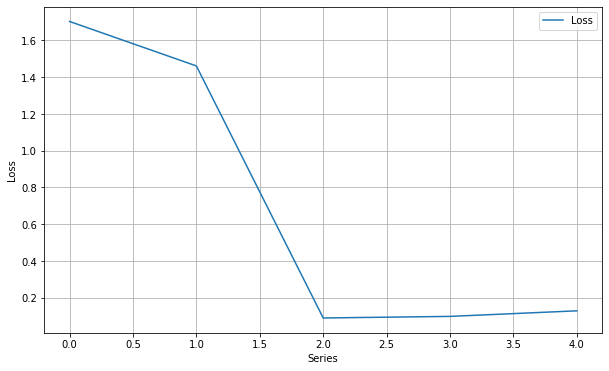

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label="Loss")

plt.xlabel('Series')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
